In [1]:
import xarray as xr
import numpy as np
import yaml
import os
import pop_tools
import esmlab
import esmlab_regrid
esmlab.config.set({'regrid.gridfile-directory' : 'scrip_grids/'})

%matplotlib inline

Open all 12 files in `/glade/work/mclong/seawifs/chl_gsm`

```
$ ls -1
S19972442010273.L3m_MC_GSM_chl_gsm_9km.nc
S19972742010304.L3m_MC_GSM_chl_gsm_9km.nc
S19973052010334.L3m_MC_GSM_chl_gsm_9km.nc
S19973352010365.L3m_MC_GSM_chl_gsm_9km.nc
S19980012010031.L3m_MC_GSM_chl_gsm_9km.nc
S19980322010059.L3m_MC_GSM_chl_gsm_9km.nc
S19980602010090.L3m_MC_GSM_chl_gsm_9km.nc
S19980912010120.L3m_MC_GSM_chl_gsm_9km.nc
S19981212010151.L3m_MC_GSM_chl_gsm_9km.nc
S19981522010181.L3m_MC_GSM_chl_gsm_9km.nc
S19981822010212.L3m_MC_GSM_chl_gsm_9km.nc
S19982132010243.L3m_MC_GSM_chl_gsm_9km.nc
```

Note that, in order, these are

```
Sept (1997 - 2010)
Oct (1997 - 2010)
Nov (1997 - 2010)
Dec (1997 - 2010)
Jan (1998 - 2010)
Feb (1998 - 2010)
March (1998 - 2010)
April (1998 - 2010)
May (1998 - 2010)
June (1998 - 2010)
July (1998 - 2010)
Aug (1998 - 2010)
```

In [2]:
def _mask_invalid_values(ds, var = 'chl_gsm', mask_val=None, keep=True, verbose=False):
    """ replace chl_gsm values above valid_max or below valid_min with np.nan """
    if 'valid_min' in ds[var].attrs:
        if not mask_val:
            min_mask = ds[var].attrs['valid_min']
        else:
            min_mask = mask_val
        if verbose:
            print(f'adjusting minimum to {min_mask}')
        ds[var].data = np.where(ds[var].data < ds[var].attrs['valid_min'], min_mask, ds[var].data)
        if not keep:
            del(ds[var].attrs['valid_min'])
    if 'valid_max' in ds[var].attrs:
        if not mask_val:
            max_mask = ds[var].attrs['valid_max']
        else:
            max_mask = mask_val
        if verbose:
            print(f'adjusting maximum to {max_mask}')
        ds[var].data = np.where(ds[var].data > ds[var].attrs['valid_max'], max_mask, ds[var].data)
        if not keep:
            del(ds[var].attrs['valid_max'])
    return(ds)

In [3]:
%%time

# Read mapping_dict from YAML
with open('mapping_dict.yaml') as yaml_file:
    mapping_dict = yaml.safe_load(yaml_file)

# Read monthly files and also generate annual datasets
dict_of_datasets = dict()
for n, month in enumerate(mapping_dict):
    file_loc = os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects', 'cesm2-marbl', 'seaWIFS-data', 'chl_gsm', mapping_dict[month]['file'])
    dict_of_datasets[month] = xr.open_dataset(file_loc)
    if n==0:
        ann_ds = dict_of_datasets[month].copy()
        ann_sum = np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), dict_of_datasets[month]['chl_gsm'].data * mapping_dict[month]['len'], 0)
        wgt_sum = np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), mapping_dict[month]['len'], 0)
    else:
        ann_sum = ann_sum + np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), dict_of_datasets[month]['chl_gsm'].data * mapping_dict[month]['len'], 0)
        wgt_sum = wgt_sum + np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), mapping_dict[month]['len'], 0)

print(f'Annual average based on {wgt_sum.max()} days in the year')
ann_ds['chl_gsm'].data = np.where(wgt_sum > 0, ann_sum / wgt_sum, np.nan)

# strip out invalid values
for month in dict_of_datasets:
    dict_of_datasets[month] = _mask_invalid_values(dict_of_datasets[month], mask_val=np.nan)
ann_ds = _mask_invalid_values(ann_ds, mask_val=np.nan)

Annual average based on 365 days in the year


/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


CPU times: user 5.19 s, sys: 2.64 s, total: 7.84 s
Wall time: 8.6 s


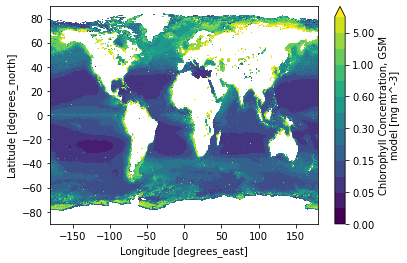

In [4]:
ann_ds['chl_gsm'].plot(levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20])

In [5]:
'''
netcdf POP_gx1v7 {
dimensions:
    grid_size = 122880 ;
    grid_rank = 2 ;
    grid_corners = 4 ;
variables:
    int grid_dims(grid_rank) ;
    double grid_center_lat(grid_size) ;
        grid_center_lat:units = "radians" ;
    double grid_center_lon(grid_size) ;
        grid_center_lon:units = "radians" ;
    double grid_area(grid_size) ;
    int grid_imask(grid_size) ;
        grid_imask:units = "unitless" ;
    double grid_corner_lat(grid_size, grid_corners) ;
        grid_corner_lat:units = "radians" ;
    double grid_corner_lon(grid_size, grid_corners) ;
        grid_corner_lon:units = "radians" ;

'''

def gen_scrip_grid(ds_in, var_for_mask):
    """
        Takes lat, lon information from seaWIFS dataset and creates a SCRIP grid file
        NOTES:
        1. using "degrees_east" and "degrees_north" instead of just "degrees" caused ESMF issues
        2. I have not yet computed grid_area correctly
    """
    # Pull grid out of dataset
    lats = ds_in['lat'].data
    nlat = len(lats)
    lons = ds_in['lon'].data
    nlon = len(lons)
    
    # Define lat_bnds and lon_bnds (to convert to corners)
    lat_bnds = np.empty_like(lats, shape=(nlat, 2))
    lat_bnds[0, 0] = 90.
    lat_bnds[1:, 0] = 0.5*(lats[1:] + lats[:-1])
    lat_bnds[:-1, 1] = 0.5*(lats[1:] + lats[:-1])
    lat_bnds[-1, 1] = -90.
    lon_bnds = np.empty_like(lons, shape=(nlon, 2))
    lon_bnds[0, 0] = -180.
    lon_bnds[1:, 0] = 0.5*(lons[1:] + lons[:-1])
    lon_bnds[:-1, 1] = 0.5*(lons[1:] + lons[:-1])
    lon_bnds[-1, 1] = 180.

    # Define lat_corners and lon_corners
    lat_corners = np.empty_like(lats, shape=(nlat, 4))
    lat_corners[:, 0] = lat_bnds[:, 1] # SW
    lat_corners[:, 1] = lat_bnds[:, 1] # SE
    lat_corners[:, 2] = lat_bnds[:, 0] # NE
    lat_corners[:, 3] = lat_bnds[:, 0] # NW

    lon_corners = np.empty_like(lons, shape=(nlon, 4))
    lon_corners[:, 0] = lon_bnds[:, 0] # SW
    lon_corners[:, 1] = lon_bnds[:, 1] # SE
    lon_corners[:, 2] = lon_bnds[:, 1] # NE
    lon_corners[:, 3] = lon_bnds[:, 0] # NW

    # Define dimensions for xarray
    grid_size = nlat*nlon
    grid_rank = 2
    grid_dims = [nlon, nlat]

    # Set up local copies of data to add to scrip dataset
    lats_repeat = np.repeat(lats[:,np.newaxis], nlon, axis=1).reshape(nlat*nlon)
    lons_repeat = np.repeat(lons[np.newaxis,:], nlat, axis=0).reshape(nlat*nlon)
    grid_imask = np.where(np.isnan(ds_in[var_for_mask].data), 0, 1).reshape(nlat*nlon)
    lat_corners_repeat = np.repeat(lat_corners[:,np.newaxis,:], nlon, axis=1).reshape((nlat*nlon, 4))
    lon_corners_repeat = np.repeat(lon_corners[np.newaxis,:,:], nlat, axis=0).reshape((nlat*nlon, 4))

    # compute grid_area
    s_lat = lat_corners_repeat[:,0]*np.pi/180 # SW
    n_lat = lat_corners_repeat[:,2]*np.pi/180 # NE
    w_lon = lon_corners_repeat[:,0]*np.pi/180 # SW
    e_lon = lon_corners_repeat[:,2]*np.pi/180 # NE
    grid_area = (np.sin(n_lat) - np.sin(s_lat))*(e_lon - w_lon)

    # Need to create scrip_ds
    scrip_ds = xr.Dataset()
    scrip_ds['grid_dims'] = xr.DataArray(grid_dims, dims='grid_rank')
    scrip_ds['grid_center_lon'] = xr.DataArray(lons_repeat, dims='grid_size')
    scrip_ds['grid_center_lat'] = xr.DataArray(lats_repeat, dims='grid_size')
    scrip_ds['grid_imask'] = xr.DataArray(grid_imask, dims='grid_size')
    scrip_ds['grid_corner_lon'] = xr.DataArray(lon_corners_repeat, dims=('grid_size', 'grid_corners'))
    scrip_ds['grid_corner_lat'] = xr.DataArray(lat_corners_repeat, dims=('grid_size', 'grid_corners'))
    scrip_ds['grid_area'] = xr.DataArray(grid_area, dims='grid_size')

    # Set units
    scrip_ds['grid_center_lon'].attrs['units'] = 'degrees'
    scrip_ds['grid_center_lat'].attrs['units'] = 'degrees'
    scrip_ds['grid_corner_lon'].attrs['units'] = 'degrees'
    scrip_ds['grid_corner_lat'].attrs['units'] = 'degrees'
    scrip_ds['grid_area'].attrs['units'] = 'radians^2'

    return scrip_ds

In [6]:
scrip_in = gen_scrip_grid(dict_of_datasets['Jan'], 'chl_gsm')
# I think I need to add grid corners?
outfile = 'scrip_grids/seaWIFS.nc'
os.system(f'rm -f {outfile}')
scrip_in.to_netcdf('scrip_grids/seaWIFS.nc')

In [7]:
np.sum(scrip_in['grid_area'].data)

12.566379

In [8]:
# TODO: want conservative map rather than bilinear

# Note: I ended up building this file in parallel using the CIME mapping tools
# $ qcmd -- ./create_ESMF_map.sh -fsrc /glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/seaWIFS.nc \
#                                -fdst /glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/POP_gx1v7.nc \
#                                -nsrc seaWIFS -ndst POP_gx1v7 -map aave
# which lead to
# $ mpirun -np 36 ESMF_RegridWeightGen --ignore_unmapped -m bilinear -w map_seaWIFS_TO_POP_gx1v7_blin.200205.nc \
#                                      -s /glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/seaWIFS.nc \
#                                      -d /glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/POP_gx1v7.nc
# followed by
# $ cp map_seaWIFS_TO_POP_gx1v7_aave.200205.nc /glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/weights/seaWIFS_to_POP_gx1v7_conservative.nc
regrid_operator = esmlab_regrid.regridder(name_grid_src='seaWIFS',
                                          name_grid_dst='POP_gx1v7', 
                                          method='conservative',
                                          overwrite_existing=False)


In [9]:
%%time

list_of_mapped_das = []
for month in dict_of_datasets:
    print(f'Interpolating data from {month}')
    list_of_mapped_das.append(regrid_operator(dict_of_datasets[month]['chl_gsm'], renormalize=True, apply_mask=True).rename({'lat' : 'nlat', 'lon' : 'nlon'}))

print('Interpolating annual data')
mapped_ann_da = regrid_operator(ann_ds['chl_gsm'], renormalize=True, apply_mask=True).rename({'lat' : 'nlat', 'lon' : 'nlon'})

Interpolating data from Jan
Interpolating data from Feb
Interpolating data from Mar
Interpolating data from Apr
Interpolating data from May
Interpolating data from Jun
Interpolating data from Jul
Interpolating data from Aug
Interpolating data from Sep
Interpolating data from Oct
Interpolating data from Nov
Interpolating data from Dec
Interpolating annual data
CPU times: user 1.26 s, sys: 1.51 s, total: 2.77 s
Wall time: 2.79 s


In [10]:
def _clean_up_new_dataset(ds):
    # 1) Clean up metadata -- remove unneeded global attributes as well as coordinates attribute from all variables that have it
    del(ds.attrs['region_mask_regions'])
    del(ds.attrs['topography_fname'])
    for var in ds.variables:
        if 'coordinates' in ds[var].attrs:
            del(ds[var].attrs['coordinates'])

    # 4) Enforce valid_min and valid_max (this would only be triggered due to mapping,
    #    so I don't think it's appropriate to replace with min and max rather than nan)
    ds = _mask_invalid_values(ds, keep=False)

    # 5) Print resulting dataset to screen
    print(f"Min value of chl_gsm: {np.nanmin(ds['chl_gsm'].data)}")
    print(f"Max value of chl_gsm: {np.nanmax(ds['chl_gsm'].data)}")

    return(ds)

In [11]:
# 1) Create template for dataset on POP grid
#    Note that I remove all variables on vertical grid and dual grid, then promote TLAT and TLONG to coordinates
ds_new = pop_tools.get_grid(grid_name='POP_gx1v7').drop(['dz', 'z_t', 'z_w', 'z_w_bot', 'KMT', 'ULAT', 'ULONG']).set_coords(['TLAT', 'TLONG'])
ds_ann_new = pop_tools.get_grid(grid_name='POP_gx1v7').drop(['dz', 'z_t', 'z_w', 'z_w_bot', 'KMT', 'ULAT', 'ULONG']).set_coords(['TLAT', 'TLONG'])

# 2) Concatenate remapped data arrays over new dimension named time
#    TODO: figure out best values for time (currently an array of str)
ds_new['chl_gsm'] = xr.concat(list_of_mapped_das, dim='month')
ds_new['month'] = [month for month in dict_of_datasets]
ds_ann_new['chl_gsm'] = mapped_ann_da

# 3) more dataset cleanup
ds_new = _clean_up_new_dataset(ds_new)
ds_ann_new = _clean_up_new_dataset(ds_ann_new)

# 4) Generate netCDF file
#    TODO: come up with a better file name
ds_new.to_netcdf('seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.nc')
ds_ann_new.to_netcdf('seaWIFS.chl_gsm.ann_climo.Sep1997_Dec2010.nc')

Min value of chl_gsm: 0.006699836696503425
Max value of chl_gsm: 99.73515978449156
Min value of chl_gsm: 0.037067072083456304
Max value of chl_gsm: 90.44320228026312


/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
